## 範例重點
* 知道如何在 keras 中加入 dropout
* 了解 dropout 中 ratio 的意義與對訓練的影響

## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras

# 神經網絡正規化
from keras.regularizers import l1, l2, l1_l2 
# 神經網絡隨機拋棄
from keras.layers import Dropout 

import matplotlib.pyplot as plt
%matplotlib inline


# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data( )

170500096/170498071 [==============================] - 6s 0us/step


# 資料前處理 - 標準化 及 獨熱編碼(OneHot Encoding)

In [0]:
def preproc_x( x, flatten = True ) :
    x = x / 255.
    if flatten:
        x = x.reshape( ( len(x), -1 ) )
    return x

def preproc_y( y, num_classes = 10 ) :
    if y.shape[ -1 ] == 1:
        y = keras.utils.to_categorical( y, num_classes )
    return y  

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 建立神經網絡模型(  L1- Regularization, SGD )

In [5]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], l1_parameter = 0, dropout_ratio = 0 ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ),
                                    name = "hidden_layer_" + str( i+1 ) )( input_layer )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio, 
                         name = "Dropout_Layer_" + str( i+1 ) )( x ) 
              
        else:
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ), 
                                    name = "hidden_layer_" + str( i+1 ) )( x )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio,
                         name = "Dropout_Layer_" + str( i+1 ) )( x )  
              
              
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'output_layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

W0718 16:48:00.777392 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 16:48:00.819787 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 16:48:00.834322 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)               0         
__________

## 設定超參數

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95  
L1_PARAMETER = 1e-6  
Dropout_Ratio = [ 0.25, 0.5 ]

## 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

## 訓練模型

In [8]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for dropout_ratio in Dropout_Ratio :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'Dropout Ratio = ' + str( dropout_ratio ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ],
                       l1_parameter = L1_PARAMETER, 
                       dropout_ratio = dropout_ratio
                       )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "dropout.-%s" % str( dropout_ratio )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

W0718 16:48:00.963029 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0718 16:48:00.965353 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 16:48:01.004122 139754024302464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Dropout Ratio = 0.25


W0718 16:48:01.114165 139754024302464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)               0         
__________

W0718 16:48:01.421015 139754024302464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 293us/step - loss: 2.2488 - acc: 0.1744 - val_loss: 2.0758 - val_acc: 0.2714
Epoch 2/50
50000/50000 [==============================] - 13s 262us/step - loss: 2.0920 - acc: 0.2426 - val_loss: 1.9854 - val_acc: 0.3193
Epoch 3/50
50000/50000 [==============================] - 13s 261us/step - loss: 2.0161 - acc: 0.2745 - val_loss: 1.9153 - val_acc: 0.3409
Epoch 4/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.9693 - acc: 0.2946 - val_loss: 1.8736 - val_acc: 0.3550
Epoch 5/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.9332 - acc: 0.3148 - val_loss: 1.8441 - val_acc: 0.3640
Epoch 6/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.9053 - acc: 0.3256 - val_loss: 1.8125 - val_acc: 0.3736
Epoch 7/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.8774 - acc: 0.3387 - val_loss: 1.

## 損失函數及準確率

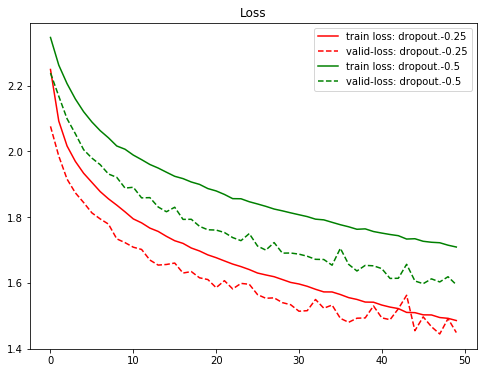

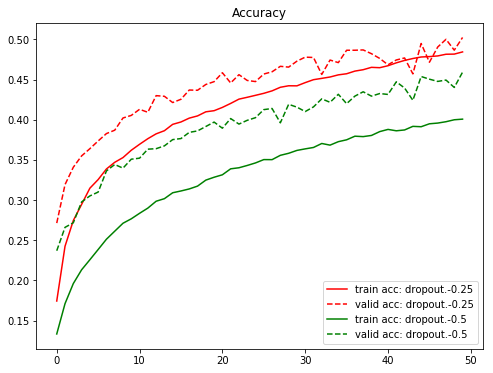

In [9]:
color_bar = [ 'r', 'g' ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = 'train loss: ' + cond, color = color_bar[i] )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = 'valid-loss: ' + cond, color = color_bar[i] )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = 'train acc: ' + cond, color = color_bar[i] )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = 'valid acc: ' + cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )

# 建立神經網絡模型( L1- Regularization, Adam )

In [10]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128, 128 ], l1_parameter = 0, dropout_ratio = 0 ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ),
                                    name = "hidden_layer_" + str( i+1 ) )( input_layer )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio, 
                         name = "Dropout_Layer_" + str( i+1 ) )( x ) 
              
        else:
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ), 
                                    name = "hidden_layer_" + str( i+1 ) )( x )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio,
                         name = "Dropout_Layer_" + str( i+1 ) )( x )  
              
              
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'output_layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)               0         
__________

## 設定超參數

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95  
L1_PARAMETER = 1e-5  
Dropout_Ratio = [ 0.25 ]

## 優化器(Optimizer)

In [0]:
Adam = keras.optimizers.Adam( lr = LEARNING_RATE, 
                              epsilon = None
                              )  

Optimizers = 'Adam' 

## 訓練模型

In [13]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for dropout_ratio in Dropout_Ratio :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'Adam with Dropout Ratio = ' + str( dropout_ratio ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ],
                       l1_parameter = L1_PARAMETER, 
                       dropout_ratio = dropout_ratio
                       )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "dropout.-%s" % str( dropout_ratio )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

Adam with Dropout Ratio = 0.25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)     

## 損失函數及準確率

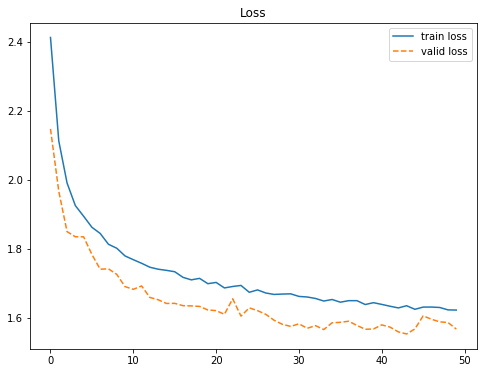

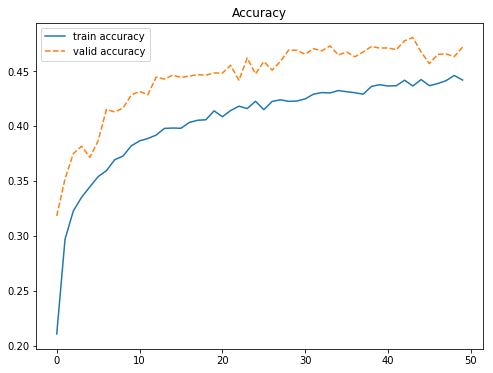

In [14]:
plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = 'train loss' )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = 'valid loss' )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = 'train accuracy' )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = 'valid accuracy' )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )